In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils import parameters_to_vector
from torchinfo import summary
from brevitas.nn import QuantConv2d

import matplotlib.pyplot as plt

from torchlop import profile

# Load Model

In [2]:
device = 'cpu'

In [3]:
# Always load Torch Model, to calculate Sparsity/MACs

import modules.model_mobilenetv2_mini_Resnet as cnv_model
torch_model = cnv_model.MobileNetV2_MINI_RESNET().to(device)
torch_model_path = './experiments/test_v04_mini_resnet_70k_full_ds/weights/MY_MBLNET_V2_classifier__best_mean_F1.pt'

In [4]:
model_name = "brevitas 70k"
# model_name = "brevitas relu6 70k"
# model_name = "brevitas scalemin 70k"

In [5]:
if model_name == "brevitas 70k":
    import modules.brevitas.model_mobilenetv2_mini_Resnet_Brevitas as cnv_model
    model = cnv_model.MobileNetV2_MINI_RESNET().to(device)
    model_path = './experiments_brevitas/test_v05_mini_resnet_70k_full_ds/weights/MY_MBLNET_V2_RESNET_classifier__best_mean_F1.pt'

elif model_name == "brevitas relu6 70k":
    import modules.brevitas.model_mobilenetv2_mini_Resnet_ReLU6_Brevitas as cnv_model
    model = cnv_model.MobileNetV2_MINI_RESNET_RELU6().to(device)
    model_path = './experiments_brevitas/test_v41_mini_resnet_70k_relu6_full_ds/weights/Mobilenetv2_ReLU6_classifier__best_mean_F1.pt'

elif model_name == "brevitas scalemin 70k":
    import modules.brevitas.model_mobilenetv2_mini_Resnet_Brevitas as cnv_model
    model = cnv_model.MobileNetV2_MINI_RESNET().to(device)
    model_path = './experiments_brevitas/test_v0501_mini_resnet_70k_ScaleMIN_full_ds/weights/Mobilenetv2_MINI_Resnet_classifier__best_mean_F1.pt'
else:
    raise Exception("Wrong Model")

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/brevitas/nn/mixin/base.py:77: UserWarning: Keyword arguments are being passed but they not being used.
  warn('Keyword arguments are being passed but they not being used.')


### Parameters

In [6]:
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')


Trainable parameters = 68914
Total parameters = 68914



### Check Model Shape: Random Input

In [7]:
dummy_input = np.random.rand(4, 3, 224, 224)
dummy_input = torch.tensor(dummy_input, dtype=torch.float32, device=device)
out_test = model(dummy_input)
print(f'Model shape is {out_test}')

/opt/conda/envs/pytorch_brevitas/lib/python3.10/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400410390/work/c10/core/TensorImpl.h:1900.)
  return super().rename(names)


Model shape is tensor([[-0.1453, -2.0159],
        [-0.1369, -1.8874],
        [-0.4905, -1.6104],
        [ 0.0826, -1.7473]], grad_fn=<AddmmBackward0>)


### Torchinfo

In [8]:
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                                                           Output Shape              Param #
MobileNetV2_MINI_RESNET                                                          [1, 2]                    --
├─Sequential: 1-1                                                                [1, 64, 14, 14]           60,206
│    └─QuantIdentity: 2-1                                                        [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-1                                       [1, 3, 224, 224]          --
│    │    └─ActQuantProxyFromInjector: 3-2                                       [1, 3, 224, 224]          1
├─Sequential: 1-72                                                               --                        (recursive)
│    └─QuantReLU: 2-88                                                           --                        (recursive)
│    │    └─ActQuantProxyFromInjector: 3-96                                      --           

## Load Checkpoint

In [9]:
def load_checkpoint(model_path, model, optimizer=None, scheduler=None, device='cpu'):
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    if optimizer is not None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    if scheduler is not None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Loading Model. Trained during {start_epoch} epochs")
    return start_epoch

In [10]:
load_checkpoint(torch_model_path, torch_model)

Loading Model. Trained during 86 epochs


86

In [11]:
load_checkpoint(model_path, model)

Loading Model. Trained during 91 epochs


91

In [12]:
torch_model.cpu();
torch_model.eval();
model.cpu();
model.eval();

# Check Sparsity

In [13]:
a = torch.tensor(np.array([[[0,1,2],[3,4,5]]]))
print(a.shape)
zzz = a == 0
print(torch.sum(zzz))

torch.Size([1, 2, 3])
tensor(1)


In [14]:
zero_channels = {}
sparsity = {}

for name, mod in model.named_modules():
    if isinstance(mod, QuantConv2d):
        print("QuantConv2d", name)
    if isinstance(mod, nn.Conv2d) or isinstance(mod, nn.BatchNorm2d):
        w_layer = mod.weight.detach().clone()
        w_layer[w_layer < 1e-20] = 0
        oup_channels = mod.weight.shape[0]
        
        if isinstance(mod, nn.Conv2d):
            layer_type = "conv"
        elif isinstance(mod, nn.BatchNorm2d):
            layer_type = "batchnorm"
        # Number of zeros to calculate sparsity
        zero_idx = w_layer < 1e-20
        zero_weights_other = torch.sum(zero_idx)
        total_weights = torch.numel(mod.weight)
        zero_weights = total_weights - torch.count_nonzero(w_layer)
        assert zero_weights == zero_weights_other, "Zeros are different"
        layer_sparsity = zero_weights / total_weights
        sparsity[name] = {"layer type": layer_type, "sparsity": layer_sparsity}
        zero_channel_list = []
        print(f'Layer name: {name} - Layer type: {layer_type} - Number of weights: {torch.numel(mod.weight)} - Sparsity: {layer_sparsity:.2f}')
        #print(f'\tWeights shape: {w_layer.shape}')
        
        for i in range(oup_channels):
            w = mod.weight[i].detach().clone()
            w[w < 1e-10] = 0
            if len(w.nonzero()) == 0:
                zero_channel_list.append(i)
        zero_channels[name] = {"layer type": layer_type, "output channels": oup_channels, "zero channels": zero_channel_list}

QuantConv2d features.1.0
Layer name: features.1.0 - Layer type: conv - Number of weights: 864 - Sparsity: 0.51
Layer name: features.1.1 - Layer type: batchnorm - Number of weights: 32 - Sparsity: 0.03
QuantConv2d features.2.conv.0
Layer name: features.2.conv.0 - Layer type: conv - Number of weights: 288 - Sparsity: 0.54
Layer name: features.2.conv.1 - Layer type: batchnorm - Number of weights: 32 - Sparsity: 0.03
QuantConv2d features.2.conv.3
Layer name: features.2.conv.3 - Layer type: conv - Number of weights: 256 - Sparsity: 0.55
Layer name: features.2.conv.4 - Layer type: batchnorm - Number of weights: 8 - Sparsity: 0.00
QuantConv2d features.3.conv.0
Layer name: features.3.conv.0 - Layer type: conv - Number of weights: 128 - Sparsity: 0.56
Layer name: features.3.conv.1 - Layer type: batchnorm - Number of weights: 16 - Sparsity: 0.00
QuantConv2d features.3.conv.3
Layer name: features.3.conv.3 - Layer type: conv - Number of weights: 144 - Sparsity: 0.40
Layer name: features.3.conv.4 -

## Sparse Zero Channels

In [15]:
for k, v in zero_channels.items():
    #print(k, v, len(v))
    print(f'Layer name: {k:<20} Layer type: {v["layer type"]:<10} - Output channels: {v["output channels"]:<4} - Zero channels: {len(v["zero channels"])}')

Layer name: features.1.0         Layer type: conv       - Output channels: 32   - Zero channels: 1
Layer name: features.1.1         Layer type: batchnorm  - Output channels: 32   - Zero channels: 1
Layer name: features.2.conv.0    Layer type: conv       - Output channels: 32   - Zero channels: 1
Layer name: features.2.conv.1    Layer type: batchnorm  - Output channels: 32   - Zero channels: 1
Layer name: features.2.conv.3    Layer type: conv       - Output channels: 8    - Zero channels: 0
Layer name: features.2.conv.4    Layer type: batchnorm  - Output channels: 8    - Zero channels: 0
Layer name: features.3.conv.0    Layer type: conv       - Output channels: 16   - Zero channels: 0
Layer name: features.3.conv.1    Layer type: batchnorm  - Output channels: 16   - Zero channels: 0
Layer name: features.3.conv.3    Layer type: conv       - Output channels: 16   - Zero channels: 2
Layer name: features.3.conv.4    Layer type: batchnorm  - Output channels: 16   - Zero channels: 0
Layer name

### Plot Zero Channels per Layer

$$
Global \, Sparsity = \frac{Zero \quad Channels}{All \quad Channels}
$$

Global Sparsity = 29.55 %


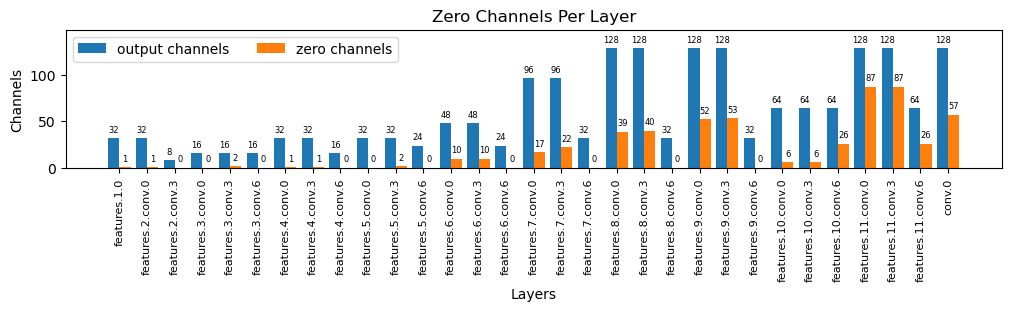

In [16]:
zero_channel_layer = {
    "output channels": list(v["output channels"] for v in zero_channels.values() if v["layer type"] == "conv"),
    "zero channels": list(len(v["zero channels"]) for v in zero_channels.values() if v["layer type"] == "conv"),
}

# Number of zero channels / Number of channels
global_sparsity = sum(zero_channel_layer["zero channels"]) / sum(zero_channel_layer["output channels"])
print(f'Global Sparsity = {global_sparsity*100:.2f} %')

zero_channels_layer_names = [k for k in zero_channels.keys() if zero_channels[k]["layer type"] == "conv"] 

x = np.arange(len(zero_channels_layer_names))  # the label locations
width = 0.4  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained', figsize=(10, 3))

for attribute, measurement in zero_channel_layer.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3, fontsize = 6)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Layers')
ax.set_ylabel('Channels')
ax.set_title('Zero Channels Per Layer')
ax.set_xticks(x + width/2, zero_channels_layer_names, rotation=90, fontsize = 8)
ax.legend(loc='upper left', ncols=3)
ax.set_ylim(0, 148)

plt.show()

## Sparsity per layer

### All Layers

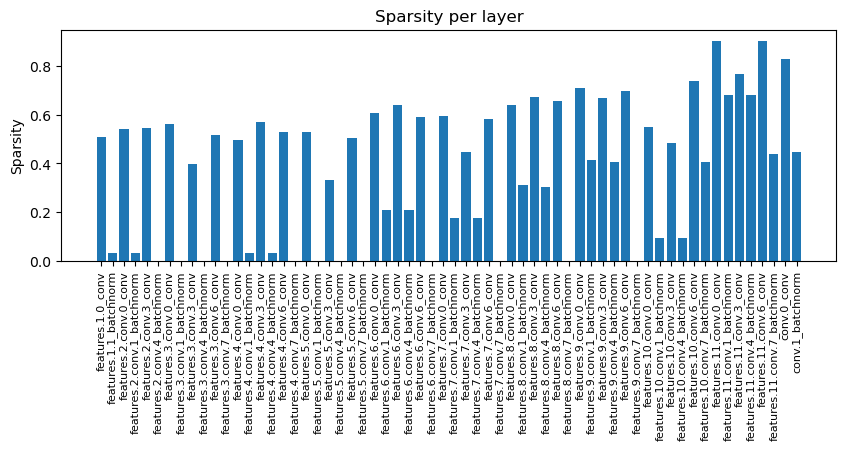

In [17]:
fig, ax = plt.subplots(figsize=(10,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys()]
counts = [v["sparsity"] for v in sparsity.values()]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()

### Only Batch Norm

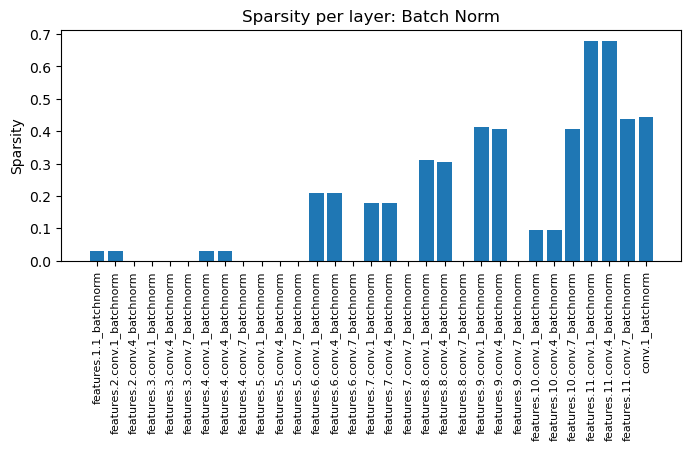

In [18]:
fig, ax = plt.subplots(figsize=(8,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys() if sparsity[k]["layer type"] == "batchnorm"]
counts = [v["sparsity"] for v in sparsity.values() if v["layer type"] == "batchnorm"]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer: Batch Norm')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()

### Only Convs

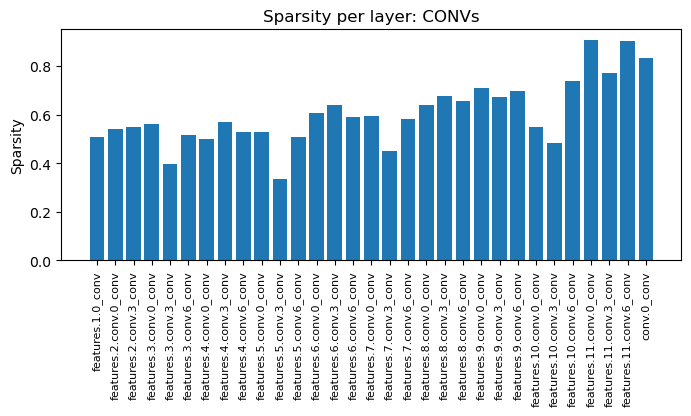

In [19]:
fig, ax = plt.subplots(figsize=(8,3))

layers_name = [k + "_" + sparsity[k]["layer type"] for k in sparsity.keys() if sparsity[k]["layer type"] == "conv"]
counts = [v["sparsity"] for v in sparsity.values() if v["layer type"] == "conv"]

ax.bar(layers_name, counts)

ax.set_ylabel('Sparsity')
ax.set_title('Sparsity per layer: CONVs')
ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)

plt.show()

# Calculate MACs reduction

Torchinfo does not include BatchNorm or AveragePool in MAC calculation

### Summary

In [20]:
print(summary(torch_model, input_size=(1, 3, 224, 224), device='cpu', verbose=0))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET                  [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   

### MACs per layer

In [21]:
torch_model.to('cpu');

In [22]:
def get_macs_and_params_per_layer(model, inp_shape = (1, 3, 224, 224), device = 'cpu'):

    dummy_inp = torch.randn(inp_shape).to(device)
    macs, params, layer_infos = profile(model, inputs=(dummy_inp, ))

    print('Total MACs of {}: {:.4g} M'.format(model.__class__.__name__, macs / 1e6))
    print('Total params of {}: {}'.format(model.__class__.__name__, params))

    macs_layer = {}
    params_layer = {}

    conv_idx = 0
    linear_idx = 0
    
    for i, k in enumerate(layer_infos.keys()):
        layer_type = layer_infos[k]["type"]
        layer_ops = layer_infos[k]["ops"]
        layer_params = layer_infos[k]["params"]
        if layer_ops != 0 and layer_type != "BatchNorm2d":
            if layer_type == "Conv2d": 
                macs_layer.update({layer_type + '_' + str(conv_idx): layer_ops})   
                params_layer.update({layer_type + '_' + str(conv_idx): layer_params}) 
                conv_idx += 1
            elif layer_type == "Linear":
                macs_layer.update({layer_type + '_' + str(linear_idx): layer_ops}) 
                params_layer.update({layer_type + '_' + str(linear_idx): layer_params})  
                linear_idx += 1 
            else:
                macs_layer.update({layer_type: layer_ops})
                params_layer.update({layer_type: layer_params})

    return macs_layer, params_layer

In [23]:
macs_layer, params_layer = get_macs_and_params_per_layer(torch_model)

Total MACs of MobileNetV2_MINI_RESNET: 45.91 M
Total params of MobileNetV2_MINI_RESNET: 68882.0


In [24]:
# Exclude BatchNorm and AveragePool
print(sum([v for k, v in macs_layer.items() if "Conv" in k or "Linear" in k]))

41815936


Calculate the sparsity of every Conv. Afterwards, the MACs will change like:

$$
New \: MACs = (1-Sparsity)\times MAC
$$

In [25]:
zero_channels_convs = {k: (len(v["zero channels"]) / v["output channels"])
                           for k, v in zero_channels.items() if v["layer type"] == "conv"}

In [26]:
new_macs_layer = {}

for (k1,v1), (k2,v2) in zip(macs_layer.items(), zero_channels_convs.items()):
    new_macs_layer[k2] = {"new": v1 * (1-v2), "old": v1}

In [27]:
total_old_macs = sum([v["old"] for v in new_macs_layer.values()])
print(f'Total Old MACs = {total_old_macs}')

total_new_macs = sum([v["new"] for v in new_macs_layer.values()])
print(f'Total New MACs = {int(total_new_macs)}')

print(f'MACs difference = {int(total_old_macs - total_new_macs)}')

Total Old MACs = 41815424
Total New MACs = 36876224
MACs difference = 4939200
